#  This is Lab 2 executable file
This file contains the program code that is the solution to the tasks from the file [lab_2_task.txt](https://github.com/vandosik/M-M-MSA/blob/master/Lab_2/lab_2_task.txt).
## Authors
* Ivan Dubinin: [vandosik](https://github.com/vandosik)
* Alexey Grandilevskii: [zer0deck](https://github.com/zer0deck)
* Mikhail Sorokin: [Mikha1lSorokin](https://github.com/Mikha1lSorokin)

In [1]:
# libs initialization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
from scipy.optimize import curve_fit 
import seaborn as sns

In [2]:
# Dataset initialization
path_to_file = '../Datasets/GameStats.csv'
source_df = pd.read_csv(path_to_file, engine='python')
# source_df.columns = ["V"+str(i) for i in range(1, len(source_df.columns)+1)]  # rename column names to be similar to R naming convention
# source_df.V2 = source_df.V2.astype(str)
source_df.head(7)

,Date,Level,NumBlocks,IsWin,ElapsedTime,Score,Accuracy
0,9/7/2019 2:43:29 PM,520,30,False,1.579998,150,0.0
1,9/7/2019 2:44:46 PM,520,30,False,3.805001,100,0.0
2,9/7/2019 2:59:20 PM,520,30,False,1.783006,50,0.0
3,9/7/2019 2:59:28 PM,520,30,True,0.263020,0,0.0
4,9/7/2019 2:59:48 PM,520,30,True,3.318019,50,0.0
5,9/7/2019 2:59:56 PM,520,30,True,3.677032,0,0.0
6,9/7/2019 3:00:15 PM,520,30,False,3.168000,100,0.0


Date:        date and time the game was auto-played

Level:       the 3-digit number is an estimate of the difficulty from a previous run

NumBlocks:   how many blocks have to be broken to win the level

IsWin:       True if autoplay broke all the blocks, False if the ball fell past the paddle

ElapsedTime: Seconds until either won or lost (game is played at 4x speed, so multiply by 4 to get an estimate of how long a human might play it)

Score:       total score when the game was won or lost

Accuracy:    the autoplay is tuned with a randomly-chosen accuracy. Higher numbers are more likely to win;

/Users/zer0deck/miniforge3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


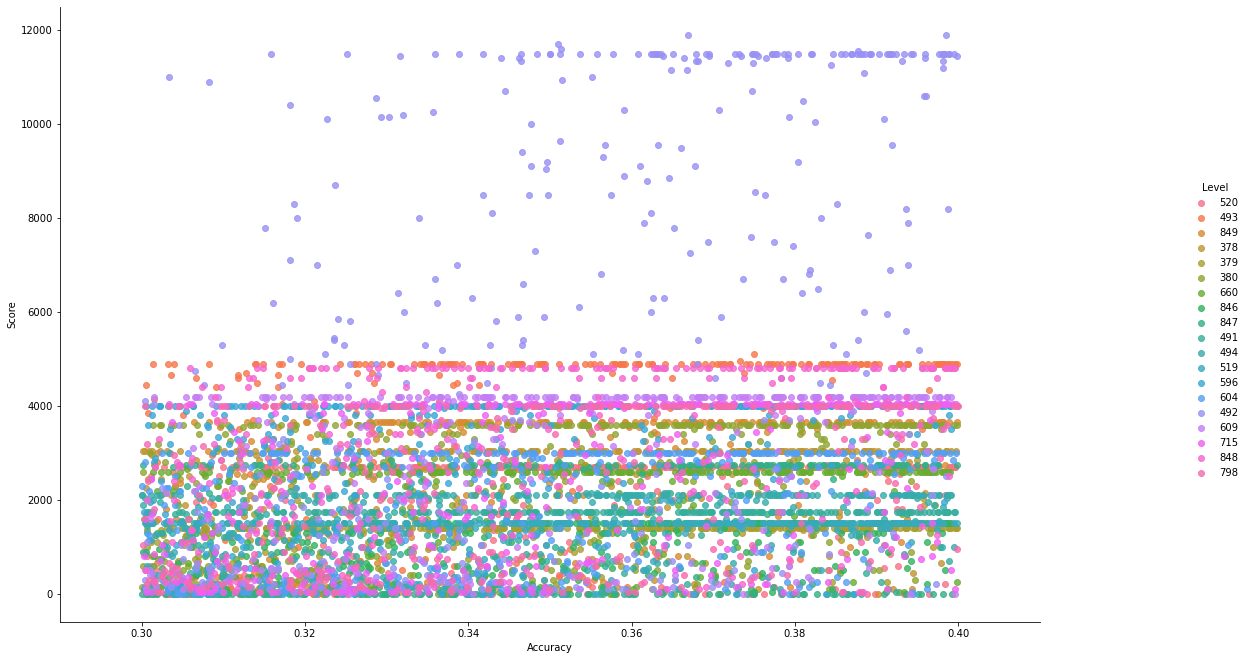

In [3]:
# Colums renaming and data preparation
source_df.Level = source_df.Level.astype(str)
b = sns.lmplot("Accuracy", "Score", source_df, hue="Level", fit_reg=False)
b.set(xlim=(0.29, 0.41))
b.fig.set_size_inches(20,10)


## Exercise №1
You need to make a non-parametric estimation of PDF in form of histogram and using kernel density function for MRV (or probability law in case of discrete MRV).

[[0.000000e+00 1.500000e+02 3.000000e+01]
 [0.000000e+00 1.000000e+02 3.000000e+01]
 [0.000000e+00 5.000000e+01 3.000000e+01]
 ...
 [3.256807e-01 4.000000e+03 5.000000e+01]
 [3.327982e-01 1.300000e+03 1.800000e+01]
 [3.811220e-01 2.100000e+03 6.200000e+01]]


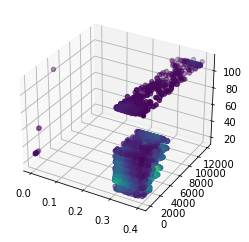

In [9]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

a = source_df["Accuracy"]
b = source_df["Score"]
c = source_df["NumBlocks"]
data = np.zeros(shape=(len(a),3))
for i in range(0, len(a)):
    data[i] = [a[i], b[i], c[i]]
print(data)

values = data.T

kde = stats.gaussian_kde(values)
density = kde(values)

fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
x, y, z = values
ax.scatter(x, y, z, c=density)
plt.show()

## Exercise №2
You need to make an estimation of multivariate mathematical expectation and variance.

## Exercise №3
You need to make a non-parametric estimation of conditional distributions, mathematical expectations and variances. 

## Exercise №4
You need to make an estimation of pair correlation coefficients, confidence intervals for them and significance levels.

## Exercise №5
Choose a task formulation for regression. Estimate multivariate correlation (target - predictors).

## Exercise №6
Build regression model and make an analysis of multicollinearity and regularization (if needed). 

## Exercise №7
Analyze the quality of regression model (distribution of residuals, determination coefficient).